In [1]:
import glob
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import re

In [2]:
image_paths = []
for image_path in glob.glob("./samples/*.bmp"):
    image_paths.append(image_path)
image_paths = sorted(image_paths)
image_paths

['./samples/Dozen_0.bmp',
 './samples/Group_1.bmp',
 './samples/Group_2.bmp',
 './samples/Group_3.bmp',
 './samples/Group_4.bmp',
 './samples/Group_5.bmp',
 './samples/Group_6.bmp',
 './samples/Path_10.bmp',
 './samples/Path_4.bmp',
 './samples/Path_5.bmp',
 './samples/Path_6.bmp',
 './samples/Path_7.bmp',
 './samples/Path_8.bmp',
 './samples/Path_9.bmp',
 './samples/Single_0.bmp',
 './samples/Single_1.bmp',
 './samples/Single_2.bmp',
 './samples/Single_3.bmp',
 './samples/Single_4.bmp',
 './samples/Single_5.bmp',
 './samples/Single_6.bmp',
 './samples/Single_7.bmp',
 './samples/Single_8.bmp',
 './samples/Single_9.bmp']

In [3]:
imgs_info = {}
for image_path in image_paths:
    name = re.sub(r"./samples/", "", image_path)
    name = re.sub(r".bmp", "", name)
    if name.find('Path') == -1:
        image = cv.imread(image_path, cv.IMREAD_COLOR)
        imgs_info[name] = dict()
        imgs_info[name]['img'] = image

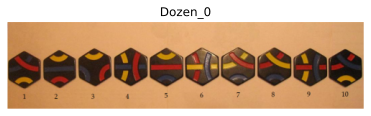

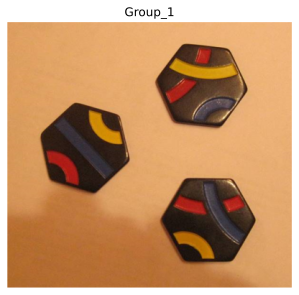

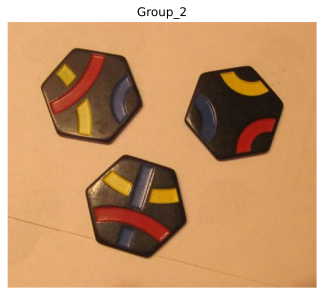

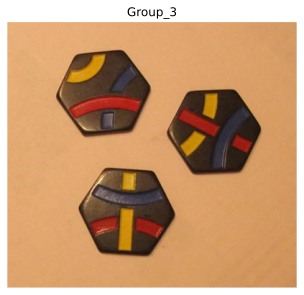

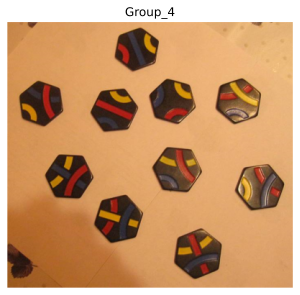

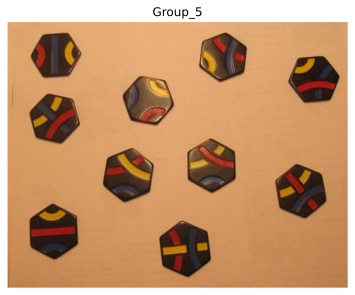

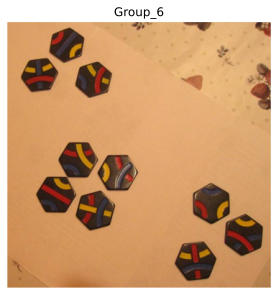

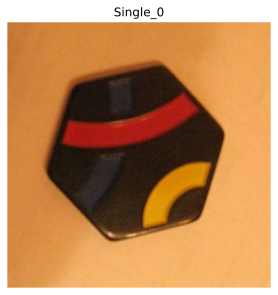

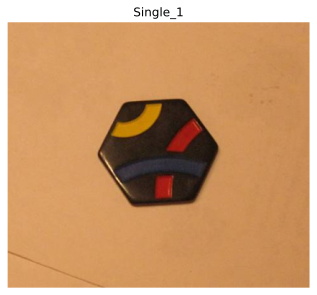

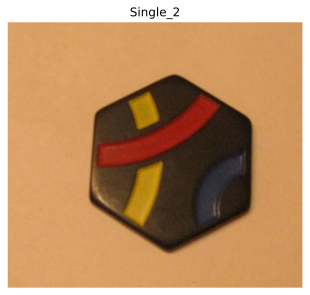

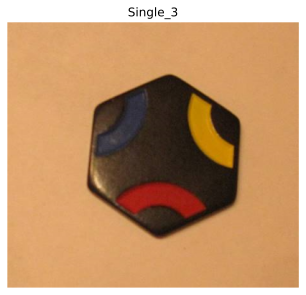

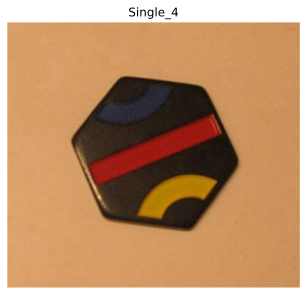

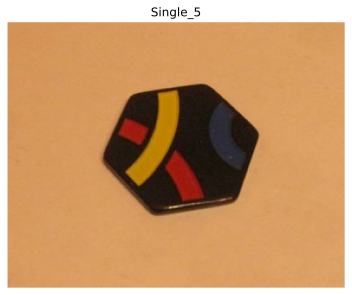

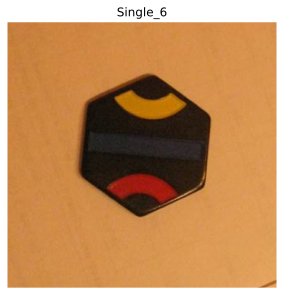

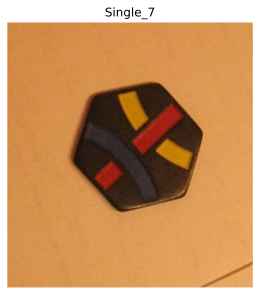

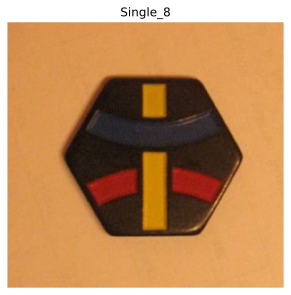

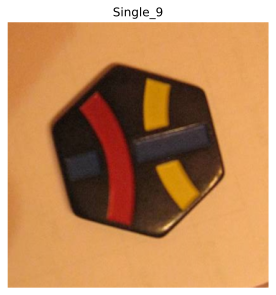

In [4]:
for fname in imgs_info:
    plt.title(fname)
    plt.axis('off')
    plt.imshow(imgs_info[fname]['img'][:,:,::-1])
    plt.show()

In [5]:
# для показа списка изображений
def show_imgs(imgs, columns, fcmap=None, ftitle='', fsize=(15, 6), format='BGR'):
    amount = len(imgs)

    fig = plt.figure(figsize=fsize)
    plt.title(ftitle)
    plt.axis('off')
    
    rows = amount // columns

    for n in range(rows * columns):
        fig.add_subplot(rows, columns, n + 1)
        if format == 'BGR':
            img = imgs[n][:,:,::-1]
        else:
            img = imgs[n]
        if fcmap is None:
            plt.imshow(img)
        else:
            plt.imshow(img, cmap=fcmap)
        plt.axis('off')
    plt.tight_layout()

In [6]:
def detect_shape(c):
    shape = ""
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.04 * peri, True)
    if len(approx) == 6:
        shape = "hexagon"
    else:
        shape = "Unknown"
    return shape

In [7]:
# возвращает маску с единицами, где пиксель принадлежит color,
# нулями в остальных местах
def mask_color(img, color):
    if color == 'blue':
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

        lower_blue = np.array([0, 0, 25])
        upper_blue = np.array([180, 80, 255])
        mask = cv.inRange(hsv, lower_blue, upper_blue)
        
        kernel  = np.ones((2,2), np.uint8)
        mask = cv.morphologyEx(mask, op=cv.MORPH_ERODE, kernel=kernel)     
        return np.clip(mask, 0, 1).astype(np.uint8)
    if color == 'yellow':
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

        lower_yellow = np.array([18, 30, 160])
        upper_yellow = np.array([35, 255, 255])

        mask = cv.inRange(hsv, lower_yellow, upper_yellow)
        return np.clip(mask, 0, 1).astype(np.uint8)
    if color == 'red':
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

        lower_red = np.array([0, 135, 125])
        upper_red = np.array([7, 255, 255])

        mask = cv.inRange(hsv, lower_red, upper_red)
        return np.clip(mask, 0, 1).astype(np.uint8)

In [8]:
def mask_hexagons(img):
    img_gr = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, img_thresh_adp = cv.threshold(img_gr,255,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

    contours, heirarchy = cv.findContours(img_thresh_adp, cv.RETR_EXTERNAL, 
        cv.CHAIN_APPROX_NONE)

    hexagon_contours = []
    hexagon_contour_areas = []
    hexagon_all_contours = []
    for c in contours:
        shape = detect_shape(c)
        if shape == 'hexagon':
            hexagon_contour_areas.append(cv.contourArea(c))
            hexagon_all_contours.append(c)
    bound = max(hexagon_contour_areas) / 2
    for idx, c in enumerate(hexagon_all_contours):
        if hexagon_contour_areas[idx] > bound:
            hexagon_contours.append(c)

    hexagon_masks = []
    for j in range(len(hexagon_contours)):
        mask = cv.drawContours(
            np.zeros(img.shape[:2]), 
            hexagon_contours, j, 
            1, thickness=-1).astype(np.uint8)
        hexagon_masks.append(mask)
    return list(zip(hexagon_masks, hexagon_contours))

In [9]:
def mask_circles(shape, approx):
    img_circles = []

    am_edges = len(approx)
    for j in range(am_edges):
        p1 = [approx[j % am_edges][0][0], approx[j][0][1]]
        p2 = [approx[(j + 1) % am_edges][0][0], 
                approx[(j + 1) % am_edges][0][1]]
        center = [(p1[i] + p2[i]) // 2 for i in range(2)]
        radius = int(0.65 *
            (((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5) / 2)
        mask = cv.circle(np.zeros(shape), center, radius, 1, -1)
        mask = mask.astype(np.uint8)
        img_circles.append(mask)
    return img_circles

In [10]:
def get_color_side(imgs_info):
    for img_name in imgs_info:
        img_rec = imgs_info[img_name]
        img_rec['hex'] = dict()
        img_masks_conts_hex = mask_hexagons(img_rec['img'])
        for idx, (mask_hex, cont_hex) in enumerate(img_masks_conts_hex):
            img = np.copy(img_rec['img'])
            img_rec['hex'][idx] = dict()
            img_rec['hex'][idx]['contour'] = cont_hex

            img = (img * mask_hex[:,:,None]).astype(dtype=np.uint8)

            # для более гладких линий
            c = cv.convexHull(cont_hex, False)

            # аппроксимируем фигурой
            peri = cv.arcLength(c, True)
            approx = cv.approxPolyDP(c, 0.04 * peri, True)

            mask_circle_list = mask_circles(img.shape[:2], approx)
            circle_list = []

            blue_mask = mask_color(img, color='blue')
            red_mask = mask_color(img, color='red')
            yellow_mask = mask_color(img, color='yellow')

            img_rec['hex'][idx]['red'] = dict()
            img_rec['hex'][idx]['yellow'] = dict()
            img_rec['hex'][idx]['blue'] = dict()

            # считаем полощадь цвета на шестиугольнике
            img_rec['hex'][idx]['red']['measure'] = np.sum(red_mask)
            img_rec['hex'][idx]['yellow']['measure'] = np.sum(yellow_mask)
            img_rec['hex'][idx]['blue']['measure'] = np.sum(blue_mask)
         

            for mask_circle in mask_circle_list:
                img_with_circle = (img * mask_circle[:,:,None]).astype(np.uint8)
                circle_list.append(img_with_circle)

            red_sides = []
            blue_sides = []
            yellow_sides = []
            for circle in circle_list:
                red_mask = mask_color(circle, color='red')
                yellow_mask = mask_color(circle, color='yellow')
                blue_mask = mask_color(circle, color='blue')

                red_sides.append(red_mask)
                yellow_sides.append(yellow_mask)
                blue_sides.append(blue_mask)

            img_rec['hex'][idx]['red']['sides'] = red_sides
            img_rec['hex'][idx]['blue']['sides'] = blue_sides
            img_rec['hex'][idx]['yellow']['sides'] = yellow_sides

In [11]:
def get_line_type(color_sides):
    color_measures = []
    for side in color_sides:
        color_measures.append(np.sum(side))
    idxs = np.argsort(color_measures)[-2:]
    dif_pos = np.abs(idxs[0] - idxs[1])
    line_type = None
    
    if dif_pos == 2 or dif_pos == 4:
        line_type = "LONG_ARC"
    elif dif_pos == 1 or dif_pos == 5:
        line_type = "SHORT_ARC"
    elif dif_pos == 3:
        line_type = "STRAIGHT_LINE"
    return line_type

In [12]:
def classify_chips(imgs_info):
    for _, img_rec in imgs_info.items():
        img = img_rec['img']
        for _, img_hex in img_rec['hex'].items():
            yellow_sides = img_hex['yellow']['sides']
            red_sides = img_hex['red']['sides']
            blue_sides = img_hex['blue']['sides']

            yellow_line = get_line_type(yellow_sides)
            red_line = get_line_type(red_sides)
            blue_line = get_line_type(blue_sides)

            type = None
            if (yellow_line == "SHORT_ARC" and 
                    red_line == "LONG_ARC" and 
                    blue_line == "LONG_ARC" and
                    img_hex['red']['measure'] > img_hex['blue']['measure']):
                type = 1

            if (yellow_line == "SHORT_ARC" and
                    red_line == "SHORT_ARC" and
                    blue_line == "STRAIGHT_LINE"):
                type = 2

            if (yellow_line == "SHORT_ARC" and
                    red_line == "SHORT_ARC" and
                    blue_line == "SHORT_ARC"):
                type = 3

            if (yellow_line == "LONG_ARC" and
                    red_line == "LONG_ARC" and
                    blue_line == "STRAIGHT_LINE"):
                type = 4

            if (yellow_line == "SHORT_ARC" and
                    red_line == "STRAIGHT_LINE" and
                    blue_line == "SHORT_ARC"):
                type = 5

            if (yellow_line == "STRAIGHT_LINE" and
                    red_line == "LONG_ARC" and
                    blue_line == "LONG_ARC"):
                type = 6

            if (yellow_line == "LONG_ARC" and
                    red_line == "LONG_ARC" and
                    blue_line == "SHORT_ARC" and
                    img_hex['red']['measure'] > img_hex['yellow']['measure']):
                type = 7

            if (yellow_line == "LONG_ARC" and
                    red_line == "LONG_ARC" and
                    blue_line == "SHORT_ARC" and
                    img_hex['red']['measure'] < img_hex['yellow']['measure']):
                type = 8

            if (yellow_line == "LONG_ARC" and
                    red_line == "STRAIGHT_LINE" and
                    blue_line == "LONG_ARC"):
                type = 9

            if (yellow_line == "SHORT_ARC" and
                    red_line == "LONG_ARC" and
                    blue_line == "LONG_ARC" and
                    img_hex['red']['measure'] < img_hex['blue']['measure']):
                type = 10
            c = img_hex['contour']
            M = cv.moments(c)
            cX = int(M["m10"] / (M["m00"] + 0.001))
            cY = int(M["m01"] / (M["m00"] + 0.001))
            img = cv.putText(np.copy(img), str(type), (cX - 20, cY), cv.FONT_HERSHEY_SIMPLEX, 2, (250, 250, 0), 2)
        img_rec['cl_img'] = img

In [13]:
get_color_side(imgs_info)

In [14]:
classify_chips(imgs_info)

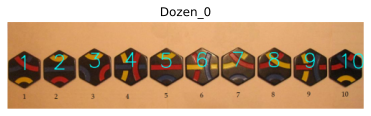

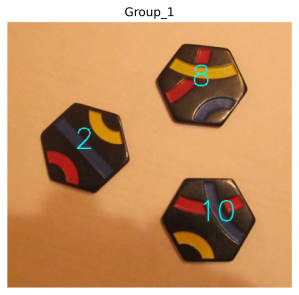

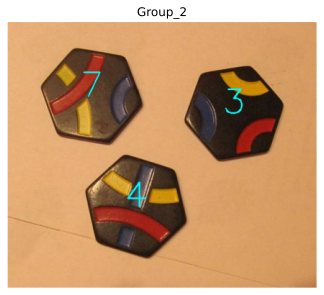

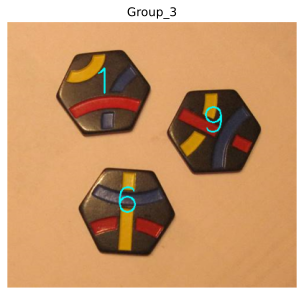

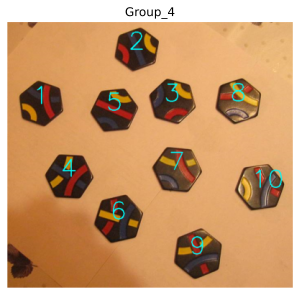

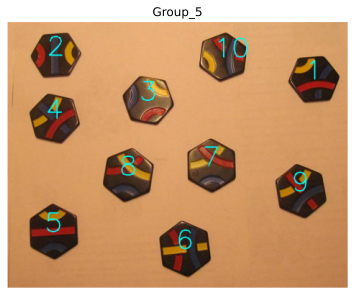

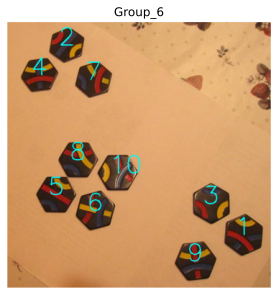

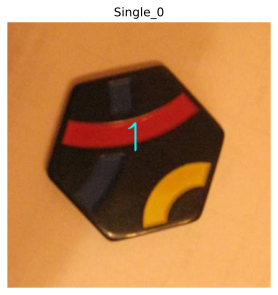

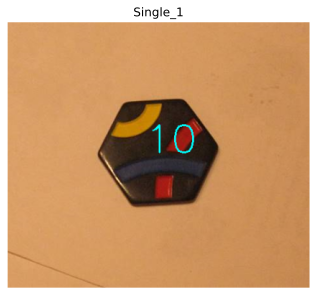

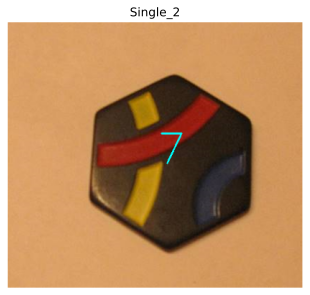

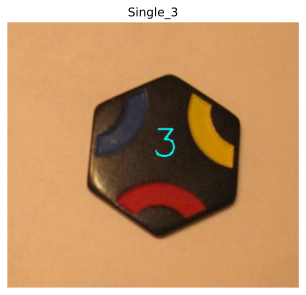

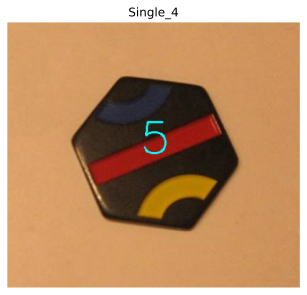

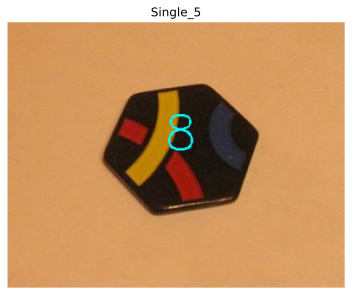

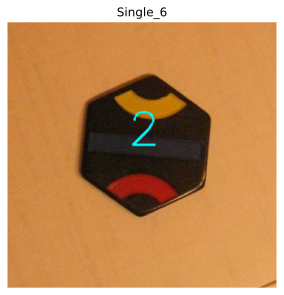

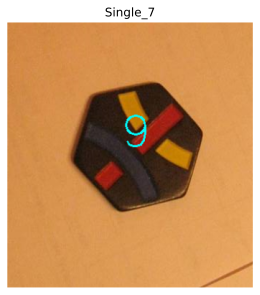

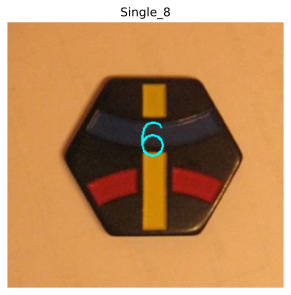

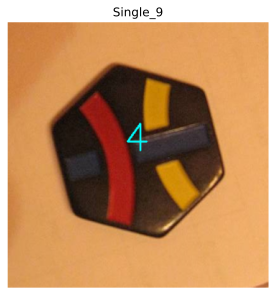

In [15]:
for fname in imgs_info:
    plt.title(fname)
    plt.axis('off')
    plt.imshow(imgs_info[fname]['cl_img'][:,:,::-1])
    plt.show()